In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
od = pd.read_csv('/content/drive/MyDrive/Colab dane/Propionate_OD.csv')
utyl = pd.read_csv('/content/drive/MyDrive/Colab dane/Propionate_kinetic.csv')

In [ ]:
utyl.head()

,STRAIN,REP,0,6,12,18,24,30,36,42,48
0,YAPO,1,27.07,28.24,27.90,26.35,25.26,23.39,21.95,19.4,18.74
1,YAPO,2,27.43,28.48,27.93,26.52,24.88,22.69,20.43,18.7,17.71
2,YAAL,1,29.10,28.60,28.43,28.33,28.77,28.34,27.56,28.5,28.49
3,YAAL,2,29.09,28.46,28.38,28.58,28.68,28.32,27.23,27.9,28.27
4,YAOS,1,28.43,28.53,27.96,26.69,25.52,24.25,22.45,21.4,19.56


In [ ]:
od.head()

,STRAIN,REP,0,6,12,18,24,30,36,42,48
0,YAPO,1,0.399,0.550,1.067,3.710,5.740,7.100,8.53,11.900,14.600
1,YAPO,2,0.466,0.640,1.100,3.440,5.870,6.980,9.14,16.300,15.900
2,YAAL,1,0.468,0.424,0.410,0.468,0.400,0.366,0.68,0.538,0.996
3,YAAL,2,0.449,0.373,0.386,0.474,0.346,0.342,0.57,0.650,0.936
4,YAOS,1,0.478,0.409,0.752,2.340,3.750,4.670,6.88,10.000,12.300


In [ ]:
mean_0 = utyl['0'].mean()
mean_0

27.88

In [ ]:
def transform( od_data, utyl_data, strain = 'STRAIN', time_start = 0, time_end= 48, time_interval = 6, init_conc = 20 ):
  import pandas as pd
  import numpy as np
  mean_0 = utyl_data['0'].mean()

  utyl = utyl_data.groupby(strain)[[str(x) for x in range(time_start, time_end+time_interval, time_interval)]].mean().reset_index()
  utyl_melt = pd.melt(utyl, id_vars='STRAIN', value_name='C_conc', var_name='Time')
  od = od_data.groupby(strain)[[str(x) for x in range(time_start, time_end+time_interval, time_interval)]].mean().reset_index()
  od_melt = pd.melt(od, id_vars='STRAIN', value_name='OD600', var_name = 'Time')

  transformed_data = pd.merge(left = od_melt, right = utyl_melt, how='left')
  transformed_data['Time'] = transformed_data['Time'].astype('int')

  transformed_data['C_conc'] = transformed_data['C_conc'].apply(lambda x: (x*init_conc)/mean_0 )
  return transformed_data

In [ ]:
prop_kinetic = transform(od_data = od, utyl_data = utyl)
prop_kinetic.head()
prop_kinetic.dtypes

STRAIN     object
Time        int64
OD600     float64
C_conc    float64
dtype: object

In [ ]:
od_ac = pd.read_csv('/content/drive/MyDrive/Colab dane/Acetate_OD.csv')
utyl_ac = pd.read_csv('/content/drive/MyDrive/Colab dane/Acetate_kinetic.csv')
act_kinetic = transform(od_ac, utyl_ac)
act_kinetic.head()

,STRAIN,Time,OD600,C_conc
0,OLHI,0,0.3975,19.889281
1,YAAL,0,0.4175,20.333613
2,YABR,0,0.3040,19.692610
3,YABU,0,0.4395,19.492297
4,YADE,0,0.3585,19.932986


In [ ]:
od_but = pd.read_csv('/content/drive/MyDrive/Colab dane/Butyrate_OD.csv')
utyl_but = pd.read_csv('/content/drive/MyDrive/Colab dane/Butyrate_kinetic.csv')
but_kinetic = transform(od_but, utyl_but)
but_kinetic['STRAIN'].unique()

array(['OLHI', 'YAAL', 'YABR', 'YABU', 'YADE', 'YADI', 'YAGA', 'YAHO',
       'YAKE', 'YALI', 'YAOS', 'YAPA', 'YAPH', 'YAPO', 'YAYA'],
      dtype=object)



> Blok z wcięciem

\

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


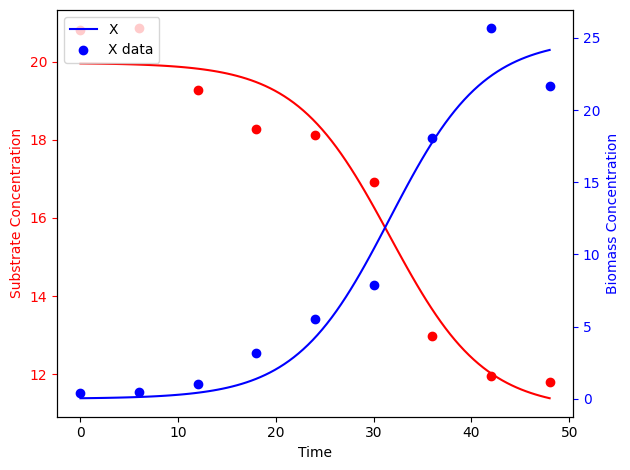

Fitted parameters:
mu_m = 0.20765319840152482
X_m = 24.97232133261145
Y_xs = 2.8170194401031856
xt0 = [ 0.03490377 19.95307126]
R2 = 0.9620309229423479


In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Set up the measured data
t = but_kinetic[but_kinetic['STRAIN']=='YADE']['Time']
x = but_kinetic[but_kinetic['STRAIN']=='YADE']['OD600']
s = but_kinetic[but_kinetic['STRAIN']=='YADE']['C_conc']


# Define the function to export the predicted measurements
def paramfun1(p, t):
    mu_m, X_m, Y_xs = p[:3]  # parameters
    xt0 = p[3:]  # initial conditions for X and S

    def f(a, t):
        X, S = a
        dXdt = mu_m * X * (1 - X / X_m)
        dSdt = -mu_m * X * (1 - X / X_m) / Y_xs
        return [dXdt, dSdt]

    ypred = odeint(f, xt0, t)
    return ypred

# Initial conditions and parameters
xt0 = np.array([0.5, 9])  # read off from data plot [x0, S0]
mu_m = 0.2  # Example initial value for mu_m
X_m = 5.0  # Example initial value for X_m
Y_xs = 0.01  # Example initial value for Y_xs
p0 = np.concatenate(([mu_m, X_m, Y_xs], xt0))

# Measurement predictions
Ypred = paramfun1(p0, t)

# Define the residual function for least squares fitting
def residual(p, t, x, s):
    Ypred = paramfun1(p, t)
    return np.concatenate((Ypred[:, 0] - x, Ypred[:, 1] - s))

# Fit the parameters using least squares
pfit = least_squares(residual, p0, args=(t, x, s))

# Extract the fitted parameters
mu_m, X_m, Y_xs = pfit.x[:3]
xt0 = pfit.x[3:]

# Generate the fitted curve
def f(a, t):
    X, S = a
    dXdt = mu_m * X * (1 - X / X_m)
    dSdt = -mu_m * X * (1 - X / X_m) / Y_xs
    return [dXdt, dSdt]

tspan = np.linspace(0, 48, 100)
a = odeint(f, xt0, tspan)

# Plot the results (substrate and biomass only)
fig, ax1 = plt.subplots()

ax1.plot(tspan, a[:, 1], 'r-', label='S')  # Substrate (S) on the left y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Substrate Concentration', color='r')
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(tspan, a[:, 0], 'b-', label='X')  # Biomass (X) on the right y-axis
ax2.set_ylabel('Biomass Concentration', color='b')
ax2.tick_params('y', colors='b')

ax1.plot(t, s, 'ro', label='S data')
ax2.plot(t, x, 'bo', label='X data')

fig.tight_layout()
plt.legend()
plt.show()

# Calculate R2
y_pred = paramfun1(pfit.x, t)
ssr = np.sum((x - y_pred[:, 0])**2) + np.sum((s - y_pred[:, 1])**2)
sst = np.sum((x - np.mean(x))**2) + np.sum((s - np.mean(s))**2)
r2 = 1 - ssr / sst

# Print the fitted parameters and R2
print("Fitted parameters:")
print("mu_m =", mu_m)
print("X_m =", X_m)
print("Y_xs =", Y_xs)
print("xt0 =", xt0)
print("R2 =", r2)

In [ ]:
apb_od = pd.read_csv('/content/drive/MyDrive/Colab dane/PAB_od.csv')
apb_utyl = pd.read_csv('/content/drive/MyDrive/Colab dane/PAB_utyl.csv', decimal=',')
apb_utyl.head()

,STRAIN,Powt,0,6,12,18,24,30,36,42,48,Carbon
0,PO,1,7.4223,7.3167,7.2340,7.8793,7.8995,7.6841,7.1320,7.1381,5.6519,A
1,PO,2,7.2545,7.5231,7.5646,7.8618,8.0692,8.2476,8.1942,6.9368,7.4688,A
2,BE,1,7.3219,7.4531,7.4193,7.4268,7.4642,7.3175,7.1758,6.8419,6.7270,A
3,BE,2,7.4725,7.4627,7.2286,7.4645,7.3614,7.3194,7.1020,6.8711,6.7251,A
4,AL,1,7.4154,7.4890,7.3694,7.7279,7.7184,7.9015,7.4624,7.7997,6.4513,A


In [ ]:
apb_utyl_gr = apb_utyl.groupby(['STRAIN', 'Carbon'])[['0','6','12','18','24', '30', '36', '42', '48']].mean().reset_index()
apb_utyl_melt = pd.melt(apb_utyl_gr, id_vars = ['STRAIN','Carbon'], var_name='Time', value_name='C_conc')

apb_act = apb_utyl_melt[apb_utyl_melt['Carbon']=='A']
apb_prop = apb_utyl_melt[apb_utyl_melt['Carbon']=='P']
apb_but = apb_utyl_melt[apb_utyl_melt['Carbon']=='B']

mean_A = apb_utyl_gr[apb_utyl_gr.Carbon == 'A']['0'].mean()
mean_P = apb_utyl_gr[apb_utyl_gr.Carbon == 'P']['0'].mean()
mean_B = apb_utyl_gr[apb_utyl_gr.Carbon == 'B']['0'].mean()

apb_act['C_conc']=apb_act['C_conc'].apply(lambda x: x*10/mean_A )
apb_prop['C_conc']=apb_prop['C_conc'].apply(lambda x: x*10/mean_P )
apb_but['C_conc']=apb_but['C_conc'].apply(lambda x: x*10/mean_B )

merged = apb_act.merge(apb_prop, on = ['STRAIN', 'Time'], suffixes = ('_A','_P'))
merged = merged.merge(apb_but, on = ['STRAIN', 'Time'])
merged = merged.drop(['Carbon_A','Carbon_P','Carbon'], axis =1)
merged = merged.rename(columns ={'C_conc':'C_Conc_B'})

merged['C_conc'] = merged['C_conc_A']+merged['C_conc_P']+merged['C_Conc_B']
apb_utyl = merged[['STRAIN','Time', 'C_conc']]
apb_utyl.head()


<ipython-input-12-f1f404aec65c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apb_act['C_conc']=apb_act['C_conc'].apply(lambda x: x*10/mean_A )
<ipython-input-12-f1f404aec65c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apb_prop['C_conc']=apb_prop['C_conc'].apply(lambda x: x*10/mean_P )
<ipython-input-12-f1f404aec65c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,STRAIN,Time,C_conc
0,AL,0,29.848701
1,BE,0,29.637271
2,BR,0,30.441170
3,BU,0,30.364077
4,DE,0,29.796372


In [ ]:
apb_od = pd.read_csv('/content/drive/MyDrive/Colab dane/PAB_od.csv', decimal =',')
apb_od = apb_od.groupby('STRAIN')[['0','6','12','18','24', '30', '36', '42', '48']].mean().reset_index()
apb_od = pd.melt(apb_od, id_vars='STRAIN', value_name='OD600', var_name='Time')
apb_od['Time'] = apb_od['Time'].astype('int')

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


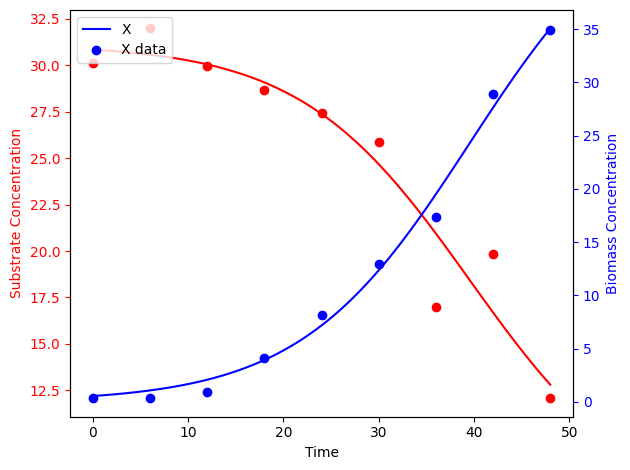

Fitted parameters:
mu_m = 0.1125896427737887
X_m = 48.59711626660425
Y_xs = 1.9113925797868094
xt0 = [ 0.55915122 30.85142391]
R2 = 0.9763481384969713


In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Set up the measured data
t = apb_od[apb_od['STRAIN']=='PH']['Time']
x = apb_od[apb_od['STRAIN']=='PH']['OD600']
s = apb_utyl[apb_utyl['STRAIN']=='PH']['C_conc']


# Define the function to export the predicted measurements
def paramfun1(p, t):
    mu_m, X_m, Y_xs = p[:3]  # parameters
    xt0 = p[3:]  # initial conditions for X and S

    def f(a, t):
        X, S = a
        dXdt = mu_m * X * (1 - X / X_m)
        dSdt = -mu_m * X * (1 - X / X_m) / Y_xs
        return [dXdt, dSdt]

    ypred = odeint(f, xt0, t)
    return ypred

# Initial conditions and parameters
xt0 = np.array([0.1, 9])  # read off from data plot [x0, S0]
mu_m = 0.1  # Example initial value for mu_m
X_m = 5.0  # Example initial value for X_m
Y_xs = 0.01  # Example initial value for Y_xs
p0 = np.concatenate(([mu_m, X_m, Y_xs], xt0))

# Measurement predictions
Ypred = paramfun1(p0, t)

# Define the residual function for least squares fitting
def residual(p, t, x, s):
    Ypred = paramfun1(p, t)
    return np.concatenate((Ypred[:, 0] - x, Ypred[:, 1] - s))

# Fit the parameters using least squares
pfit = least_squares(residual, p0, args=(t, x, s))

# Extract the fitted parameters
mu_m, X_m, Y_xs = pfit.x[:3]
xt0 = pfit.x[3:]

# Generate the fitted curve
def f(a, t):
    X, S = a
    dXdt = mu_m * X * (1 - X / X_m)
    dSdt = -mu_m * X * (1 - X / X_m) / Y_xs
    return [dXdt, dSdt]

tspan = np.linspace(0, 48, 100)
a = odeint(f, xt0, tspan)

# Plot the results (substrate and biomass only)
fig, ax1 = plt.subplots()

ax1.plot(tspan, a[:, 1], 'r-', label='S')  # Substrate (S) on the left y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Substrate Concentration', color='r')
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(tspan, a[:, 0], 'b-', label='X')  # Biomass (X) on the right y-axis
ax2.set_ylabel('Biomass Concentration', color='b')
ax2.tick_params('y', colors='b')

ax1.plot(t, s, 'ro', label='S data')
ax2.plot(t, x, 'bo', label='X data')

fig.tight_layout()
plt.legend()
plt.show()

# Calculate R2
y_pred = paramfun1(pfit.x, t)
ssr = np.sum((x - y_pred[:, 0])**2) + np.sum((s - y_pred[:, 1])**2)
sst = np.sum((x - np.mean(x))**2) + np.sum((s - np.mean(s))**2)
r2 = 1 - ssr / sst

# Print the fitted parameters and R2
print("Fitted parameters:")
print("mu_m =", mu_m)
print("X_m =", X_m)
print("Y_xs =", Y_xs)
print("xt0 =", xt0)
print("R2 =", r2)

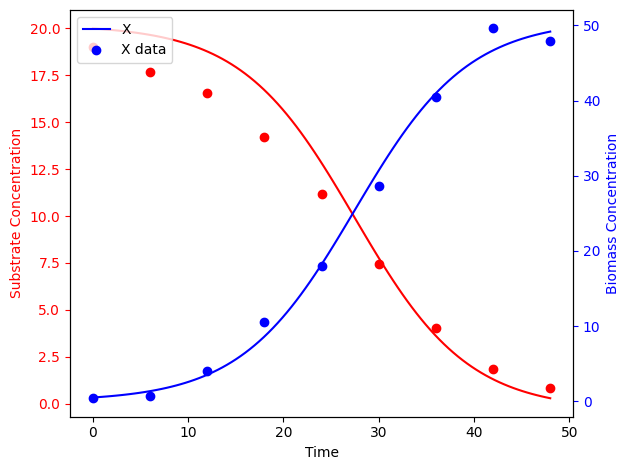

Fitted parameters:
mu_m = 0.1678893460821427
X_m = 50.75081281711894
Y_xs = 2.4703131789936035
Initial conditions: X0 = 0.5 S0 = 20
R2 = 0.989465540789978


In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Set up the measured data
t = but_kinetic[but_kinetic['STRAIN']=='YALI']['Time']
x = but_kinetic[but_kinetic['STRAIN']=='YALI']['OD600']
s = but_kinetic[but_kinetic['STRAIN']=='YALI']['C_conc']

# Define the function to export the predicted measurements
def paramfun1(p, t):
    mu_m, X_m, Y_xs = p[:3]  # parameters
    xt0 = np.array([0.5, 20])  # Set the initial conditions for X and S

    def f(a, t):
        X, S = a
        dXdt = mu_m * X * (1 - X / X_m)
        dSdt = -mu_m * X * (1 - X / X_m) / Y_xs
        return [dXdt, dSdt]

    ypred = odeint(f, xt0, t)
    return ypred

# Initial conditions and parameters
mu_m = 0.2  # Example initial value for mu_m
X_m = 5.0  # Example initial value for X_m
Y_xs = 0.01  # Example initial value for Y_xs
p0 = np.array([mu_m, X_m, Y_xs])

# Measurement predictions
Ypred = paramfun1(p0, t)

# Define the residual function for least squares fitting
def residual(p, t, x, s):
    Ypred = paramfun1(p, t)
    return np.concatenate((Ypred[:, 0] - x, Ypred[:, 1] - s))

# Set the bounds for the parameters


# Fit the parameters using least squares with bounds
pfit = least_squares(residual, p0, args=(t, x, s))

# Extract the fitted parameters
mu_m, X_m, Y_xs = pfit.x

# Generate the fitted curve
def f(a, t):
    X, S = a
    dXdt = mu_m * X * (1 - X / X_m)
    dSdt = -mu_m * X * (1 - X / X_m) / Y_xs
    return [dXdt, dSdt]

tspan = np.linspace(0, 48, 100)
a = odeint(f, [0.5, 20], tspan)  # Set the initial conditions for X and S

# Plot the results (substrate and biomass only)
fig, ax1 = plt.subplots()

ax1.plot(tspan, a[:, 1], 'r-', label='S')  # Substrate (S) on the left y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Substrate Concentration', color='r')
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(tspan, a[:, 0], 'b-', label='X')  # Biomass (X) on the right y-axis
ax2.set_ylabel('Biomass Concentration', color='b')
ax2.tick_params('y', colors='b')

ax1.plot(t, s, 'ro', label='S data')
ax2.plot(t, x, 'bo', label='X data')

fig.tight_layout()
plt.legend()
plt.show()

# Calculate R2
y_pred = paramfun1(pfit.x, t)
ssr = np.sum((x - y_pred[:, 0])**2) + np.sum((s - y_pred[:, 1])**2)
sst = np.sum((x - np.mean(x))**2) + np.sum((s - np.mean(s))**2)
r2 = 1 - ssr / sst

# Print the fitted parameters and R2
print("Fitted parameters:")
print("mu_m =", mu_m)
print("X_m =", X_m)
print("Y_xs =", Y_xs)
print("Initial conditions: X0 =", 0.5, "S0 =", 20)
print("R2 =", r2)



In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def growth_plots(data, title, color_carbon):
    # Get unique strains from the 'STRAIN' column
    strains = data['STRAIN'].unique()

    # Set up the subplots
    num_strains = len(strains)
    num_rows = int(np.ceil(num_strains / 3))
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows), gridspec_kw={'hspace': 0.2})
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, strain in enumerate(strains):
        # Set up the measured data for the current strain
        t = data[data['STRAIN'] == strain]['Time']
        x = data[data['STRAIN'] == strain]['OD600']
        s = data[data['STRAIN'] == strain]['C_conc']

        # Define the function to export the predicted measurements
        def paramfun1(p, t):
            mu_m, X_m, Y_xs = p[:3]  # parameters
            xt0 = np.array([0.5, 20])  # Set the initial conditions for X and S

            def f(a, t):
                X, S = a
                dXdt = mu_m * X * (1 - X / X_m)
                dSdt = -mu_m * X * (1 - X / X_m) / Y_xs
                return [dXdt, dSdt]

            ypred = odeint(f, xt0, t)
            return ypred

        # Initial conditions and parameters
        mu_m = 0.2  # Example initial value for mu_m
        X_m = 5.0  # Example initial value for X_m
        Y_xs = 0.01  # Example initial value for Y_xs
        p0 = np.array([mu_m, X_m, Y_xs])

        # Measurement predictions
        Ypred = paramfun1(p0, t)

        # Define the residual function for least squares fitting
        def residual(p, t, x, s):
            Ypred = paramfun1(p, t)
            return np.concatenate((Ypred[:, 0] - x, Ypred[:, 1] - s))

        # Set the bounds for the parameters


        # Fit the parameters using least squares with bounds
        pfit = least_squares(residual, p0, args=(t, x, s))

        # Extract the fitted parameters
        mu_m, X_m, Y_xs = pfit.x

        # Generate the fitted curve
        def f(a, t):
            X, S = a
            dXdt = mu_m * X * (1 - X / X_m)
            dSdt = -mu_m * X * (1 - X / X_m) / Y_xs
            return [dXdt, dSdt]

        tspan = np.linspace(0, 48, 100)
        a = odeint(f, [0.5, 20], tspan)  # Set the initial conditions for X and S

        # Plot the results (substrate and biomass only)
        row = i // 3
        col = i % 3
        ax1 = axs[row, col]

        ax1.plot(tspan, a[:, 1], label='S', color = color_carbon)  # Substrate (S) on the left y-axis
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Substrate Concentration')


        ax2 = ax1.twinx()
        ax2.plot(tspan, a[:, 0], label='X', color='red')  # Biomass (X) on the right y-axis
        ax2.set_ylabel('Biomass Concentration')


        ax1.plot(t, s,'o', color = color_carbon , label='S data')
        ax2.plot(t, x, 'ro', label='X data')

        ax1.set_title(f'Strain: {strain}')  # Add strain name as title to each subplot

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
           # Set a big title above all subplots
        fig.suptitle(title, fontsize=16)

    # Remove any empty subplots
    for i in range(num_strains, num_rows * 3):
        axs.flatten()[i].axis('off')

    fig.tight_layout()
    plt.show()




<ipython-input-96-0d4169f121ab>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


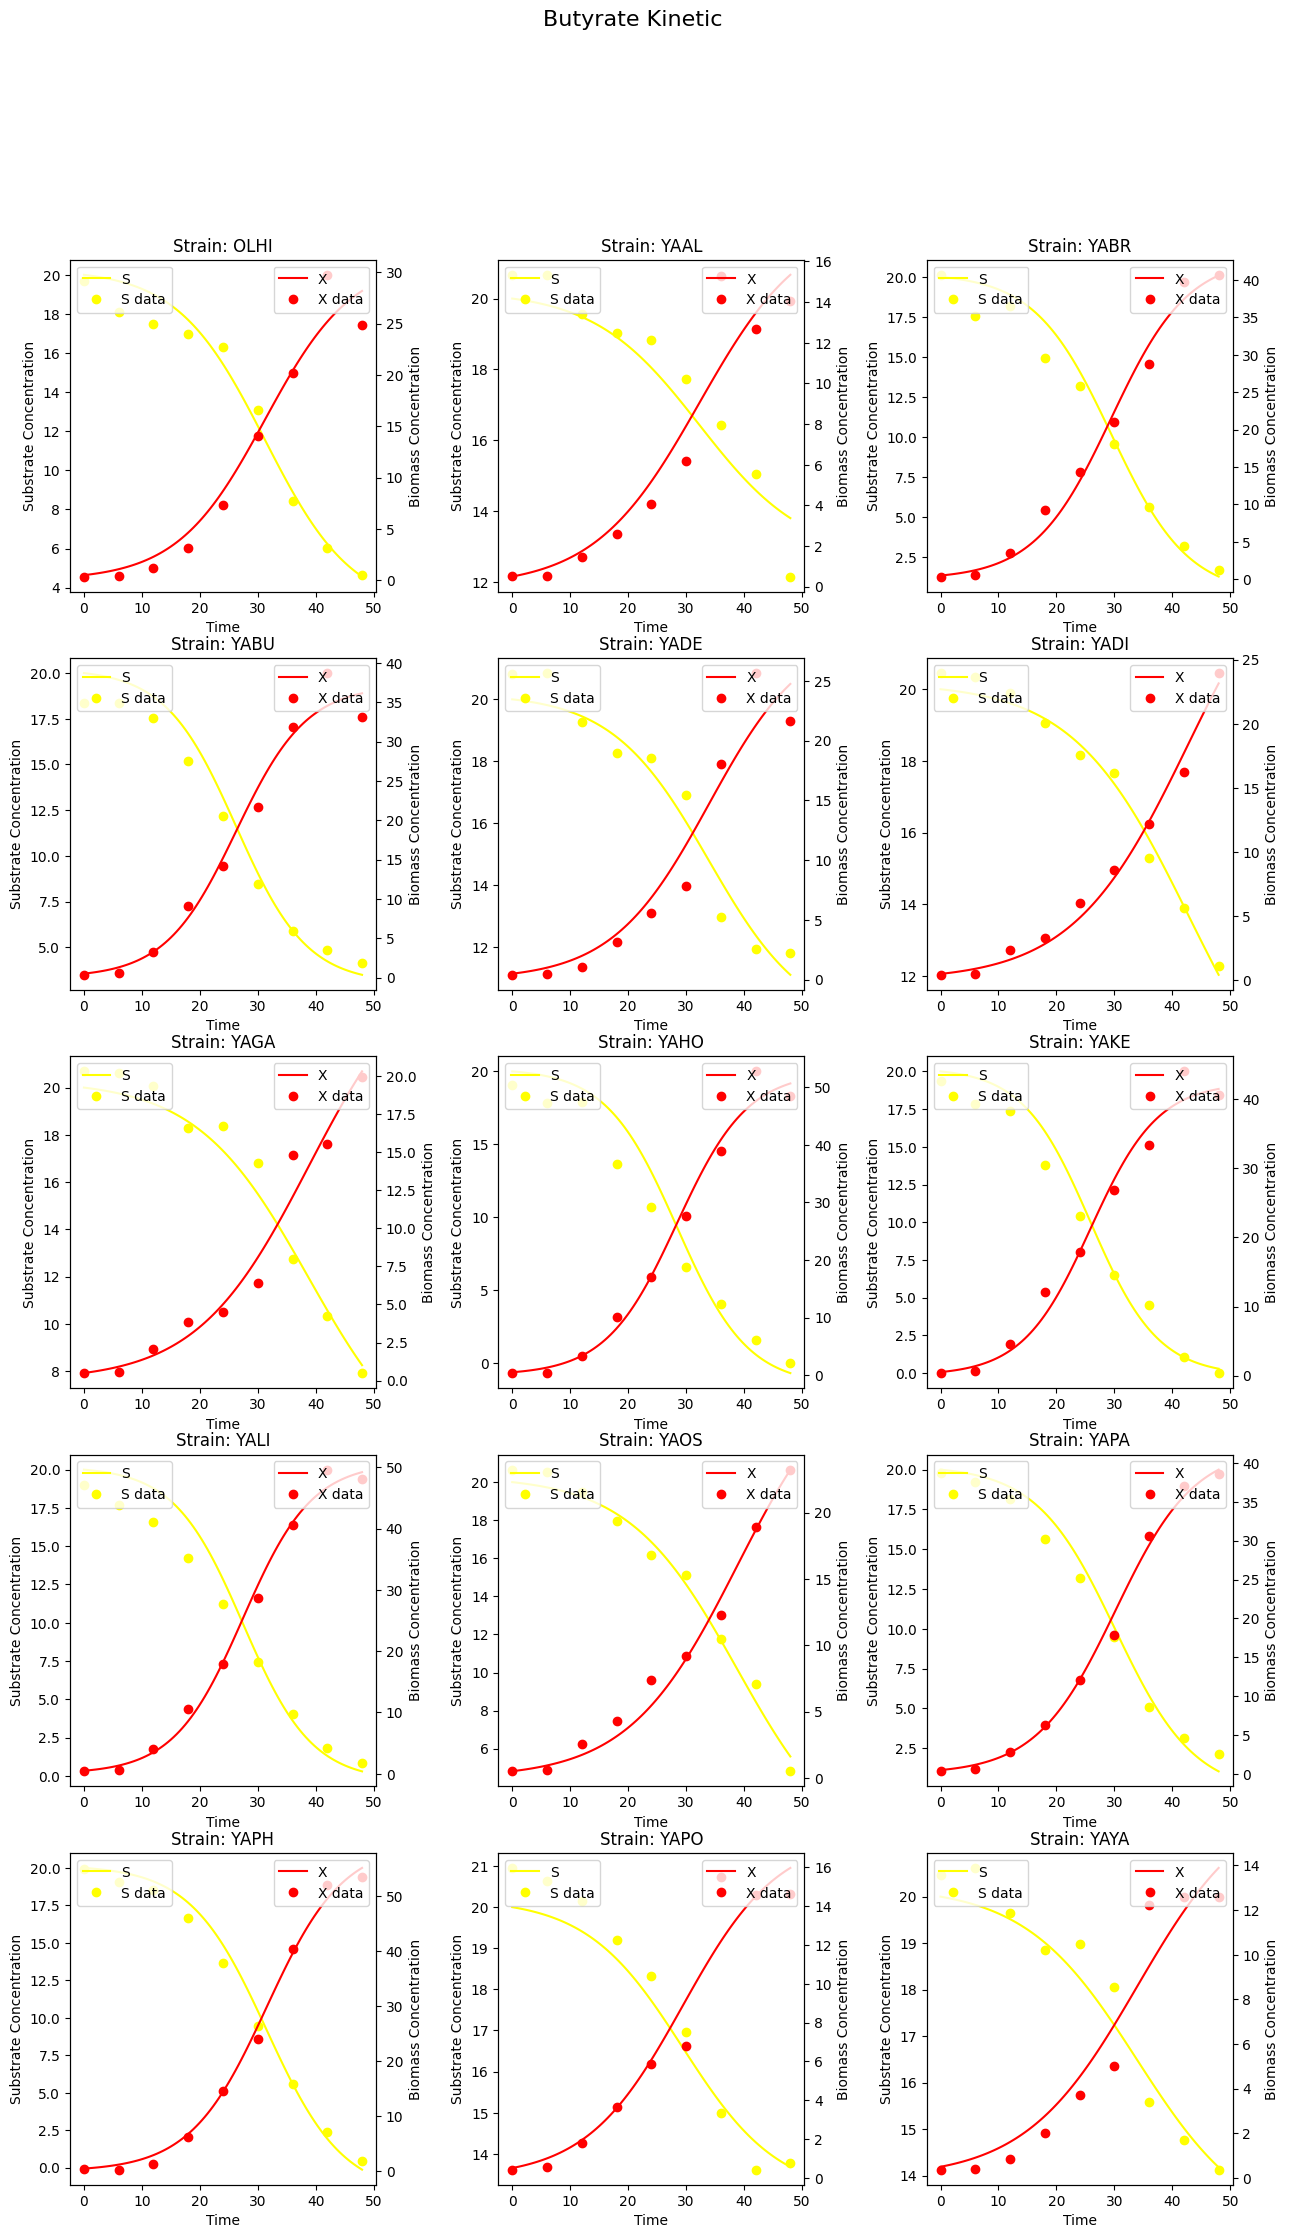

In [ ]:
growth_plots(but_kinetic, 'Butyrate Kinetic', 'yellow')

<ipython-input-96-0d4169f121ab>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


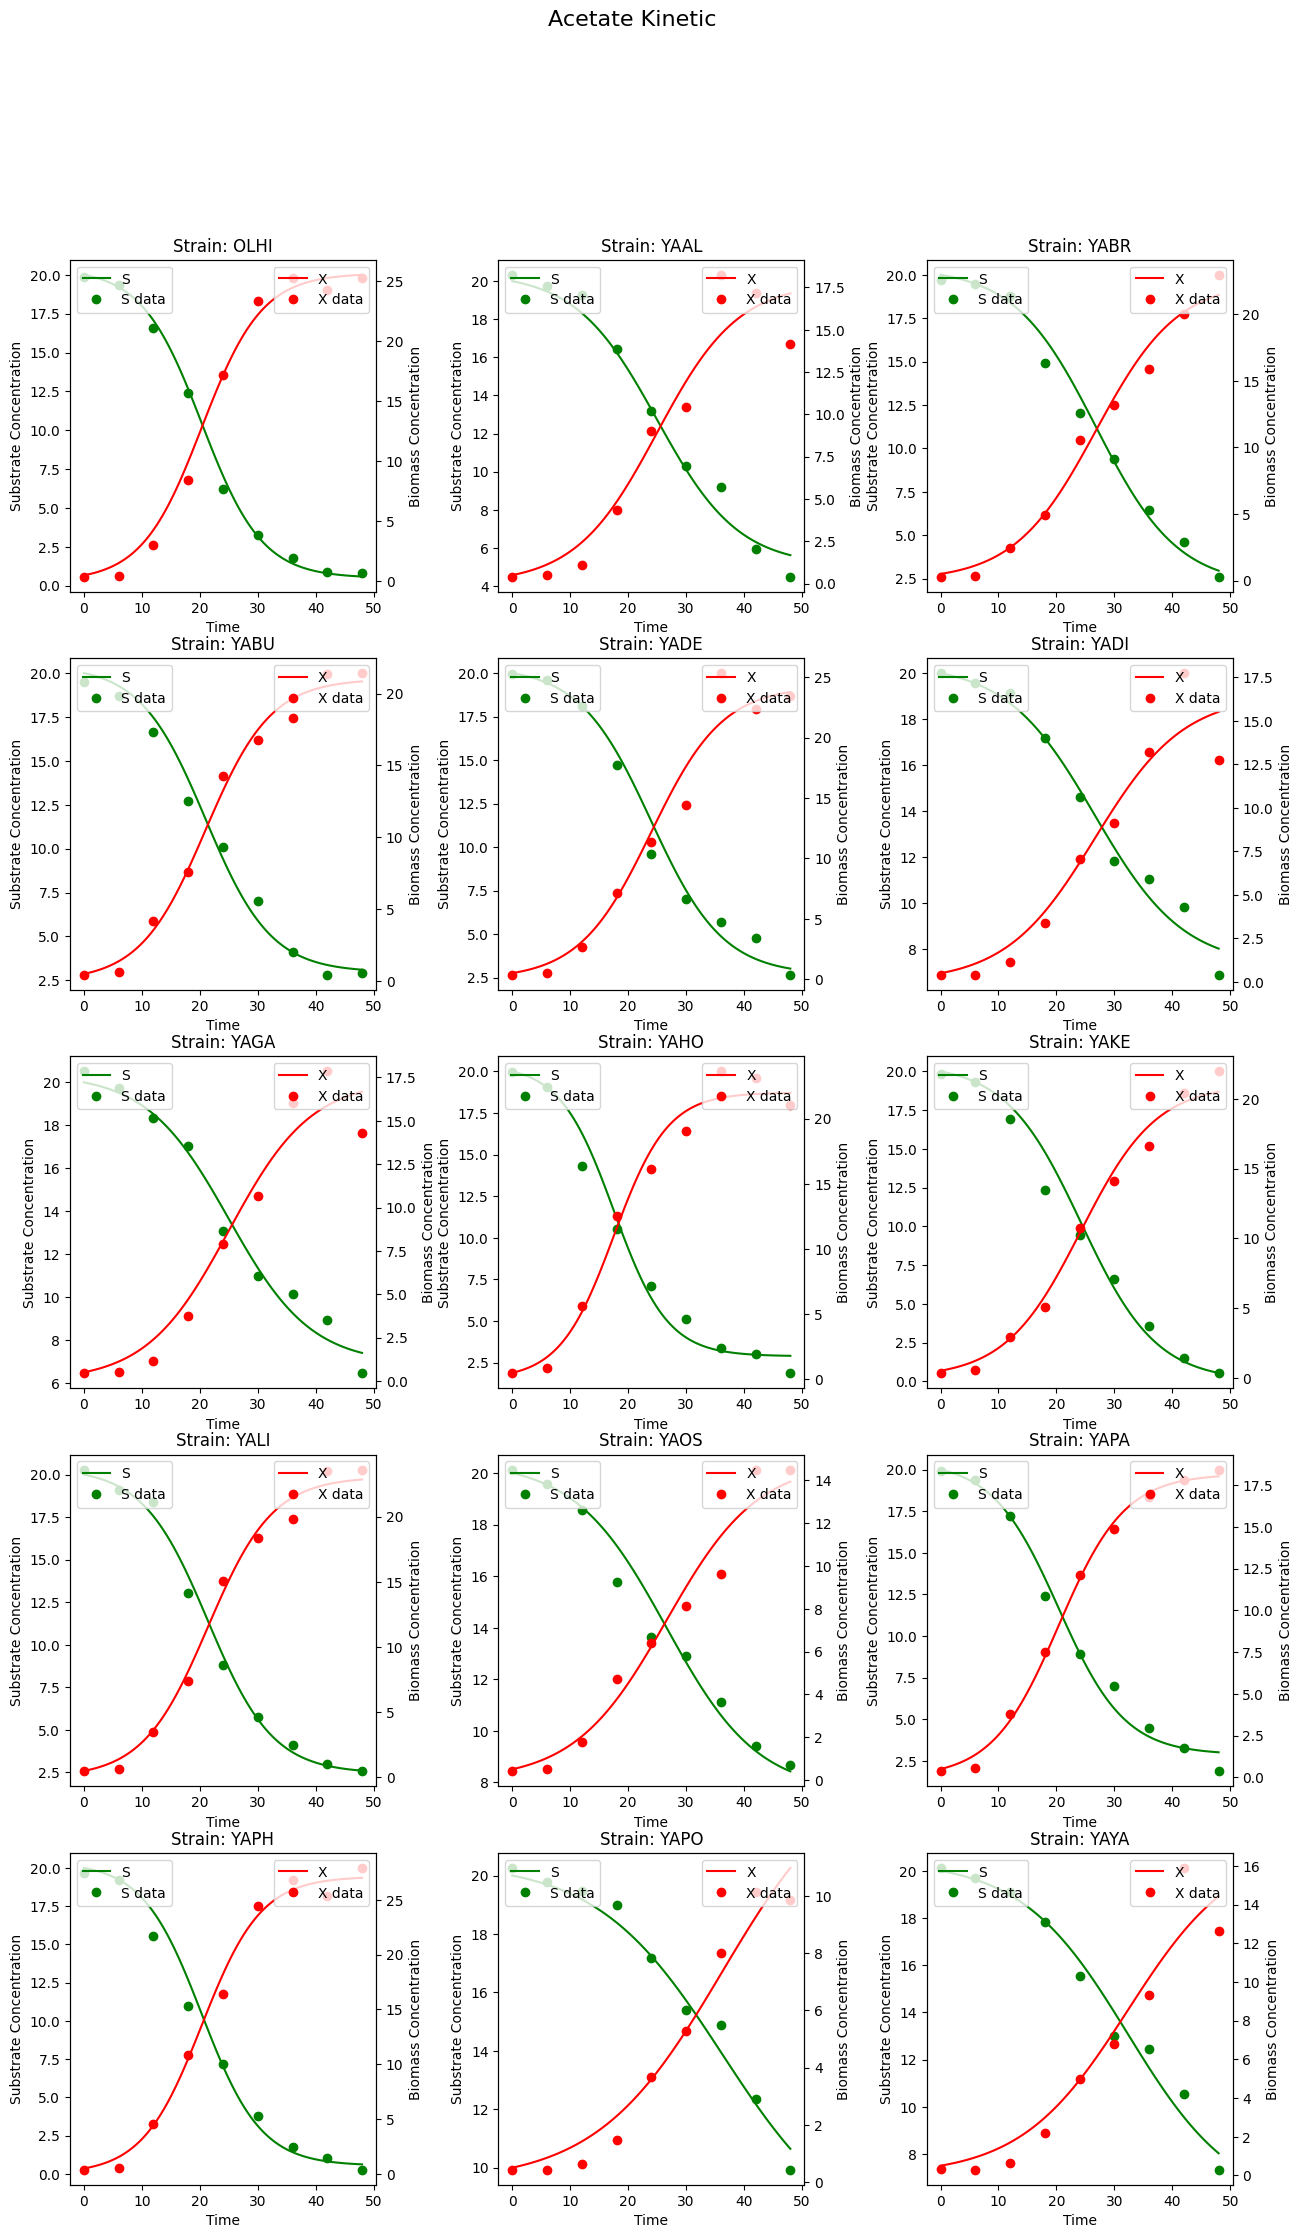

In [ ]:
growth_plots(act_kinetic, 'Acetate Kinetic', 'green')

<ipython-input-96-0d4169f121ab>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


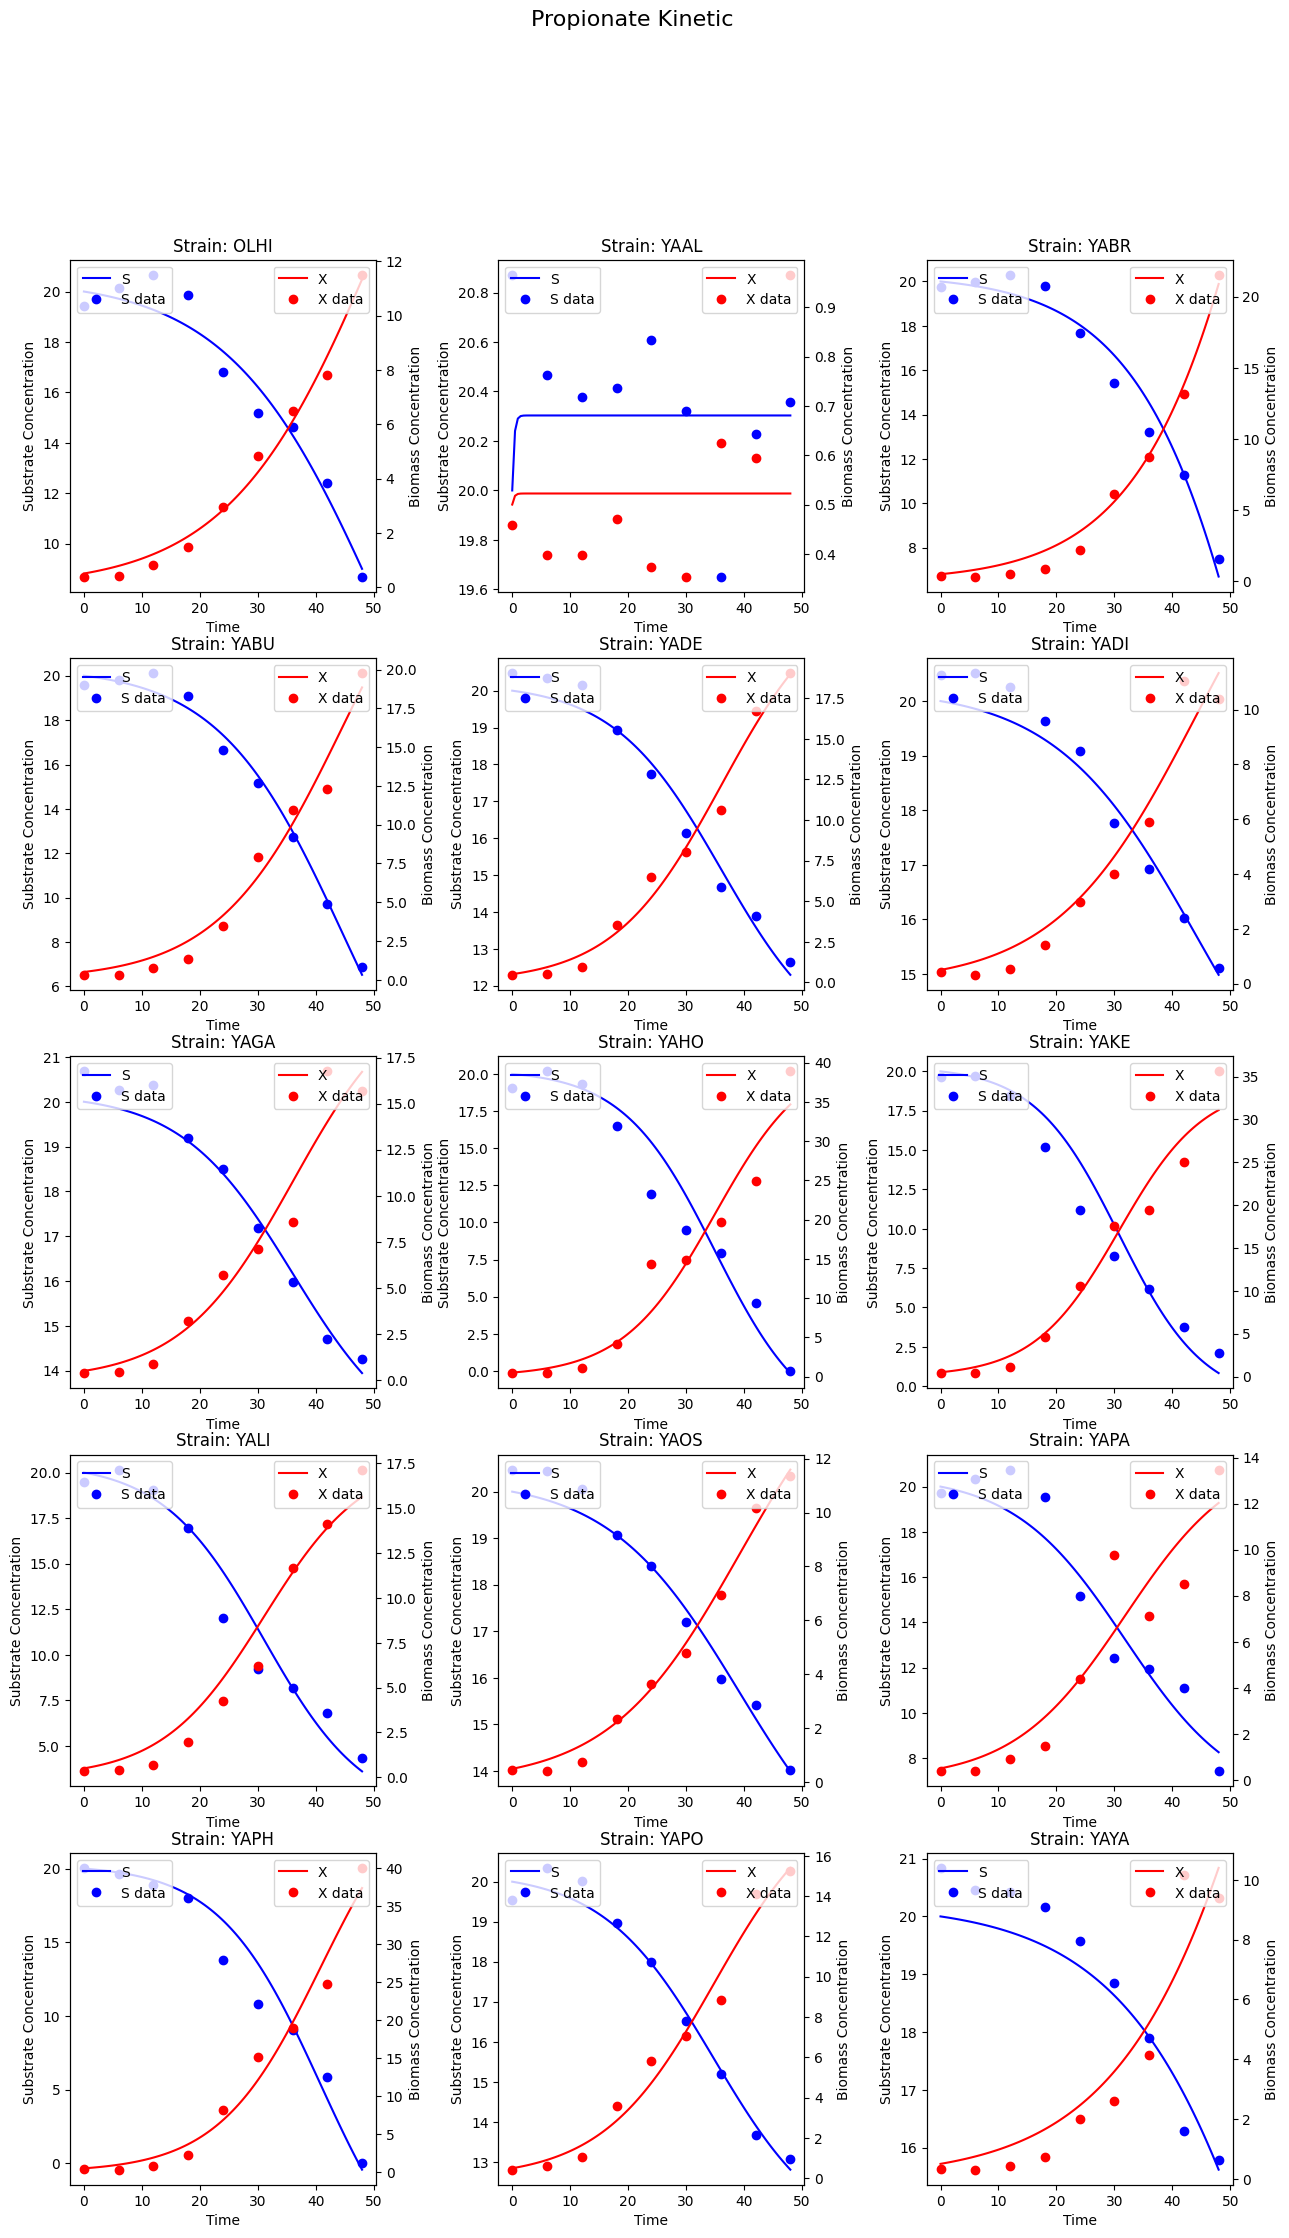

In [ ]:
growth_plots(prop_kinetic, 'Propionate Kinetic', 'blue')